In [1]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchshow as ts
import pickle

In [2]:
# Dense Block
class DenseBlock(nn.Module):
    '''
    Dense Block for Feature Extraction
    '''
    def __init__(self, in_channels):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels+8, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels+2*8, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels+3*8, 8, kernel_size=3, padding=1)

    def forward(self, x):
            x1 = F.relu(self.conv1(x))
            x2 = F.relu(self.conv2(torch.cat([x, x1], dim=1)))
            x3 = F.relu(self.conv3(torch.cat([x, x1, x2], dim=1)))
            x4 = F.relu(self.conv4(torch.cat([x, x1, x2, x3], dim=1)))
            out = torch.cat([x, x1, x2, x3, x4], dim=1)
            return out
    
# Testing

tensor = torch.randn(size=(32,2,513,600))
block = DenseBlock(in_channels=2)
out = block(tensor)

# Validation
print(f'Soll: [32,34,513,600]; Ist {out.shape}')

Soll: [32,34,513,600]; Ist torch.Size([32, 34, 513, 600])


In [3]:
class TransitionDown(nn.Module):
    '''
    Reduces the frequency dimension while keeping the time dimensions
    '''
    def __init__(self, in_channels, stride):
        super(TransitionDown, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 1), stride=(stride, 1),ceil_mode=True)

    def forward(self, x):
        x = F.relu(self.conv(x))
        out = self.avg_pool(x)
        return out
    
tensor = torch.randn(size=(16,34,513,600))
tdown = TransitionDown(in_channels=34,stride=2)
out = tdown(tensor)
out.shape

torch.Size([16, 34, 257, 600])

In [7]:
class TransitionUp(nn.Module):
    '''
    Expands the frequency dimension while keeping the time dimensions. Always returns 16 channels.
    '''
    def __init__(self, in_channels, out_channels=16, stride=1):
        super(TransitionUp, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels=in_channels,
                                            out_channels=out_channels,
                                            kernel_size=(3, 1),
                                            stride=(stride, 1),
                                            padding=(1, 0),
                                            output_padding=0)

    def forward(self, x):
        out = F.relu(self.transconv(x))
        return out
    
tensor = torch.randn(size=(8, 1, 32, 600))  # Example batch of size 8
tup = TransitionUp(in_channels=1, stride=2)
out = tup(tensor)

print(f'Should be: [8, 16, 63, 600]; Actual: {out.shape}')



Should be: [8, 16, 63, 600]; Actual: torch.Size([8, 16, 63, 600])


In [ ]:
class TransitionFinal(nn.Module):
    '''
    Collapses the channels into 1
    '''
    def __init__(self, in_channels):
        super(TransitionFinal, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        out = self.conv(x)
        return out  # out.squeeze(1) would remove the singleton channel dimension

# Testing
tensor = torch.randn(size=(1, 50, 69, 600))  # Example batch of size 8
tfinal = TransitionFinal(in_channels=50)
out = tfinal(tensor)

print(f'Should be: [1, 1, 69, 600]; Actual: {out.shape}')


In [9]:
class LinearCompressor(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearCompressor, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self, x):
        # Get the original shape
        orig_shape = x.shape
        
        # Reshape the tensor to be [batch_size, channel * 600, 69]
        x = x.view(orig_shape[0], -1, self.linear.in_features)
        
        # Apply the linear layer
        x = self.linear(x)
        
        # Apply the LeakyReLU activation
        x = self.leaky_relu(x)
        
        # Reshape the tensor back to the original shape but with the second dimension replaced
        x = x.view(orig_shape[0], orig_shape[1], self.linear.out_features, -1)
        
        return x


compressor = LinearCompressor(69, 32)
x = torch.rand(8,1, 69, 600)  # Example batch of size 8
x_compressed = compressor(x)

print(x_compressed.shape)  # Should output: torch.Size([8, 32, 600])

compressor = LinearCompressor(32, 65)
x = torch.rand(8,1, 32, 600)  # Example batch of size 8
x_compressed = compressor(x)

print(x_compressed.shape)  # Should output: torch.Size([8, 65, 26])



torch.Size([8, 1, 32, 600])
torch.Size([8, 1, 65, 600])


torch.Size([8, 4, 69, 600])


/Users/luca/Desktop/ML/SignalReconstructionML/.venv/lib/python3.10/site-packages/torchshow/visualization.py:378: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


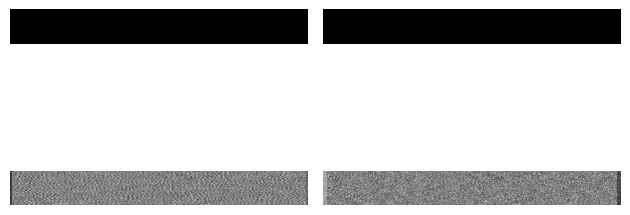

In [17]:
# Temporal Block
import torch
import torch.nn as nn

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TemporalBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 1), dilation=(1, 1))
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 2), dilation=(1, 2))
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 4), dilation=(1, 4))
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 8), dilation=(1, 8))

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out2 = self.relu(self.conv2(x))
        out3 = self.relu(self.conv3(x))
        out4 = self.relu(self.conv4(x))

        out = torch.cat((out1, out2, out3, out4), dim=1)  # Concatenate along the channel axis

        return out
    
x = torch.rand(8,1, 69, 600) 
tb = TemporalBlock(1,1)

x = tb(x)
print(x.shape)

ts.show(x[0])


